In [1]:
# !pip3 install wandb duckduckgo_search -qq

In [2]:
from fastcore.all import *
from fastai.vision.widgets import *
from fastdownload import download_url
from fastai.vision.all import *
from time import sleep
import pandas as pd
import wandb
import params
import utils
from torchvision.models import efficientnet_b0
from fastai.callback.wandb import WandbCallback

In [3]:
train_config = SimpleNamespace(
    framework="fastai",
    img_size=(180, 320),
    batch_size=8,
    augment=True, # use data augmentation
    epochs=10, 
    lr=2e-3,
    pretrained=True,  # whether to use pretrained encoder
    seed=42,
)

In [4]:
set_seed(train_config.seed, reproducible=True)

In [5]:
run = wandb.init(project=params.WANDB_PROJECT, entity=params.ENTITY, job_type="training", config=train_config)

wandb: Currently logged in as: gsparsh. Use `wandb login --relogin` to force relogin


In [6]:
processed_data_at = run.use_artifact(f'{params.PROCESSED_DATA_AT}:latest')
processed_dataset_dir = Path(processed_data_at.download())
df = pd.read_csv(processed_dataset_dir / 'data_split.csv')

wandb: Downloading large artifact bcc_bigcats_split:latest, 51.75MB. 597 files... 
wandb:   597 of 597 files downloaded.  
Done. 0:0:0.1


In [7]:
df = pd.read_csv(processed_dataset_dir / 'data_split.csv')

In [8]:
path = processed_dataset_dir/'bcc_images'

In [9]:
#assign paths
df['image_fname'] = [f for f in get_image_files(path)]
df['label'] = [utils.label_func(f) for f in df.image_fname.values]

In [10]:
df = df[df.stage != 'test'].reset_index(drop=True)
df['is_valid'] = df.stage == 'valid'

In [11]:
def get_data(df, bs=4, img_size=(180, 320), augment=True):
    block = DataBlock(blocks=(ImageBlock, CategoryBlock),
                  get_x=ColReader("image_fname"),
                  get_y=ColReader("label"),
                  splitter=ColSplitter(),
                  item_tfms=Resize(img_size),
                  batch_tfms=aug_transforms() if augment else None,
                 )
    return block.dataloaders(df, bs=bs, shuffle=True)

In [12]:
config = wandb.config

In [13]:
dls = get_data(df, bs=config.batch_size, img_size=config.img_size, augment=config.augment)

Exception in thread SystemMonitor:
Traceback (most recent call last):
  File "/usr/lib/python3.9/threading.py", line 980, in _bootstrap_inner
    self.run()
  File "/usr/lib/python3.9/threading.py", line 917, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/local/lib/python3.9/dist-packages/wandb/sdk/internal/system/system_monitor.py", line 118, in _start
    asset.start()
  File "/usr/local/lib/python3.9/dist-packages/wandb/sdk/internal/system/assets/cpu.py", line 166, in start
    self.metrics_monitor.start()
  File "/usr/local/lib/python3.9/dist-packages/wandb/sdk/internal/system/assets/interfaces.py", line 168, in start
    logger.info(f"Started {self._process.name}")
AttributeError: 'NoneType' object has no attribute 'name'


In [14]:
metrics = [accuracy, error_rate, F1Score(average='weighted'), HammingLoss()]
# metrics = [accuracy]
learn = vision_learner(dls, arch=resnet18, pretrained=config.pretrained, metrics=metrics)

/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [15]:
callbacks = [
    SaveModelCallback(monitor='accuracy'),
    WandbCallback(log_preds=False, log_model=True)
]

In [16]:
learn.fit_one_cycle(config.epochs, config.lr, cbs=callbacks)

epoch,train_loss,valid_loss,accuracy,error_rate,f1_score,hamming_loss,time
0,2.728424,0.805764,0.700000,0.300000,0.674747,0.300000,00:03
1,1.674079,0.253210,0.933333,0.066667,0.934656,0.066667,00:01
2,1.109031,0.245669,0.900000,0.100000,0.905454,0.100000,00:01
3,0.889344,0.346257,0.833333,0.166667,0.831665,0.166667,00:01
4,0.709195,0.101597,0.966667,0.033333,0.966330,0.033333,00:01
5,0.612992,0.190045,0.933333,0.066667,0.934656,0.066667,00:01
6,0.482688,0.232208,0.900000,0.100000,0.905454,0.100000,00:01
7,0.447194,0.359660,0.866667,0.133333,0.873545,0.133333,00:01
8,0.386941,0.388388,0.866667,0.133333,0.872120,0.133333,00:01
9,0.333533,0.331783,0.833333,0.166667,0.842776,0.166667,00:01


Better model found at epoch 0 with accuracy value: 0.699999988079071.
Better model found at epoch 1 with accuracy value: 0.9333333373069763.
Better model found at epoch 4 with accuracy value: 0.9666666388511658.


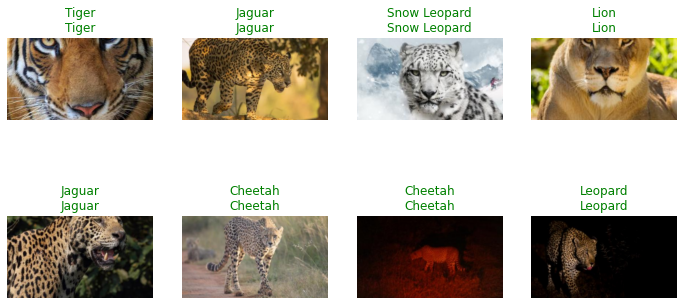

In [17]:
learn.show_results()

In [18]:
samples, outputs, predictions = utils.get_predictions(learn)
table = utils.create_prob_table(samples, outputs, predictions, params.BIG_CAT_CLASSES)
wandb.log({"pred_table":table})

In [19]:
scores = learn.validate()
metric_names = ['final_loss'] + [f'final_{x}' for x in ['accuracy', 'error_rate', 'f1score_weighted', 'hamming_loss']]
final_results = {metric_names[i] : scores[i] for i in range(len(scores))}
for k,v in final_results.items():
    wandb.summary[k] = v

In [20]:
wandb.finish()

accuracy,▁▇▆▅█▇▆▅▅▅
epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
eps_0,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
eps_1,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
eps_2,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
error_rate,█▂▃▅▁▂▃▄▄▅
f1_score,▁▇▇▅█▇▇▆▆▅
hamming_loss,█▂▃▄▁▂▃▄▄▄
lr_0,▁▁▂▃▄▅▆▇▇██████▇▇▇▇▇▆▆▅▅▅▄▄▄▃▃▃▂▂▂▂▁▁▁▁▁
lr_1,▁▁▂▃▄▅▆▇▇██████▇▇▇▇▇▆▆▅▅▅▄▄▄▃▃▃▂▂▂▂▁▁▁▁▁
lr_2,▁▁▂▃▄▅▆▇▇██████▇▇▇▇▇▆▆▅▅▅▄▄▄▃▃▃▂▂▂▂▁▁▁▁▁
